In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import plotly
import plotly.express as px
import plotly.io as pio
import missingno as ms
from dowhy import CausalModel
import dowhy.plotter
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Fitness_trackers.csv')
df.head()

Brand Name  Device Type    Model Name  Color Selling Price Original Price  \
0     Xiaomi  FitnessBand  Smart Band 5  Black         2,499          2,999   
1     Xiaomi  FitnessBand  Smart Band 4  Black         2,099          2,499   
2     Xiaomi  FitnessBand      HMSH01GE  Black         1,722          2,099   
3     Xiaomi  FitnessBand  Smart Band 5  Black         2,469          2,999   
4     Xiaomi  FitnessBand        Band 3  Black         1,799          2,199   

          Display  Rating (Out of 5)              Strap Material  \
0  AMOLED Display                4.1  Thermoplastic polyurethane   
1  AMOLED Display                4.2  Thermoplastic polyurethane   
2     LCD Display                3.5                     Leather   
3  AMOLED Display                4.1  Thermoplastic polyurethane   
4    OLED Display                4.3                     Plastic   

   Average Battery Life (in days) Reviews  
0                              14     NaN  
1                              14     NaN  
2                              14     NaN  
3                              14     NaN  
4                               7     NaN

In [18]:
# df['Selling Price'] = df['Selling Price'].astype(str)
# df['Original Price'] = df['Original Price'].astype(str)

In [13]:
df['Original Price'] = df['Original Price'].astype(str).str.replace(",", "").astype(float)
df['Selling Price'] = df['Selling Price'].astype(str).str.replace(",", "").astype(float)

In [15]:
df.dtypes

Brand Name                         object
Device Type                        object
Model Name                         object
Color                              object
Selling Price                     float64
Original Price                    float64
Display                            object
Rating (Out of 5)                 float64
Strap Material                     object
Average Battery Life (in days)      int64
Reviews                            object
dtype: object

In [16]:
df['Discount'] = df['Original Price'] - df['Selling Price']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brand Name                      565 non-null    object 
 1   Device Type                     565 non-null    object 
 2   Model Name                      565 non-null    object 
 3   Color                           565 non-null    object 
 4   Selling Price                   565 non-null    float64
 5   Original Price                  565 non-null    float64
 6   Display                         565 non-null    object 
 7   Rating (Out of 5)               514 non-null    float64
 8   Strap Material                  565 non-null    object 
 9   Average Battery Life (in days)  565 non-null    int64  
 10  Reviews                         78 non-null     object 
 11  Discount                        565 non-null    float64
dtypes: float64(4), int64(1), object(7)
m

In [19]:
# df['Selling Price'] = pd.to_numeric(df['Selling Price'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df_cleaned = df.dropna(subset=['Selling Price', 'Reviews'])

df_cleaned.dtypes, df_cleaned.head()

(Brand Name                         object
 Device Type                        object
 Model Name                         object
 Color                              object
 Selling Price                     float64
 Original Price                    float64
 Display                            object
 Rating (Out of 5)                 float64
 Strap Material                     object
 Average Battery Life (in days)      int64
 Reviews                           float64
 Discount                          float64
 dtype: object,
    Brand Name  Device Type     Model Name  \
 7      Xiaomi   Smartwatch        Revolve   
 8      Xiaomi   Smartwatch  RevolveActive   
 73      Honor  FitnessBand         Band 6   
 74      Honor  FitnessBand         Band 4   
 75      Honor  FitnessBand         Band 3   
 
                                             Color  Selling Price  \
 7                                           Black        12349.0   
 8                                           Black  

In [24]:
# Selecting the features (independent variables) and the target (dependent variable)
X = df_cleaned[['Brand Name', 'Device Type', 'Model Name', 'Color', 'Selling Price',
        'Original Price', 'Display', 'Strap Material', 'Average Battery Life (in days)', 'Reviews', 'Discount']]
y = df_cleaned['Rating (Out of 5)']

# Handling categorical variables and missing values
numeric_features = ['Selling Price', 'Original Price', 'Average Battery Life (in days)', 'Reviews', 'Discount']
categorical_features = ['Brand Name', 'Device Type', 'Model Name', 'Color', 'Display', 'Strap Material']

# Define preprocessing for numeric and categorical features
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first preprocesses the data and then applies the regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.14286678777484255
R^2 Score: -0.6692787617690412


In [ ]:
X = df_cleaned['Selling Price']
y = df_cleaned['Reviews']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>The regression analysis suggests that there is no significant relationship between the price of the headphones and the number of reviews. This could imply that other factors not included in the model are likely influencing the number of reviews.

In [25]:
df['Rating (Out of 5)'].fillna(0,inplace = True)

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression
# import pandas as pd
# import matplotlib.pyplot as plt

# # Initialize a linear regression model
# estimator = LinearRegression()

# # Initialize RFE with cross-validation
# selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')

# # Preprocess the data using the same preprocessing pipeline
# # Apply preprocessing separately to avoid mismatch
# X_train_preprocessed = model.named_steps['preprocessor'].fit_transform(X_train)
# X_test_preprocessed = model.named_steps['preprocessor'].transform(X_test)

# # Convert to dense format if necessary
# X_train_dense = X_train_preprocessed.toarray()
# X_test_dense = X_test_preprocessed.toarray()

# # Fit the RFECV selector
# selector.fit(X_train_dense, y_train)

# # Print the number of selected features and their indices
# print(f"Number of selected features: {selector.n_features_}")
# print(f"Selected feature indices: {selector.support_}")
# print(f"Feature ranking: {selector.ranking_}")

# # Plot number of features vs. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross-validation score (neg. MSE)")
# plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
# plt.show()

# # Get the selected features
# selected_features = X_train_preprocessed.columns[selector.support_]
# print("Selected features:")
# print(selected_features)

# # Refit the model using only the selected features
# X_train_selected = selector.transform(X_train_dense)
# X_test_selected = selector.transform(X_test_dense)

# # Add a constant to the model
# X_train_selected = sm.add_constant(X_train_selected)
# X_test_selected = sm.add_constant(X_test_selected)

# # Fit the model with selected features
# model_sm = sm.OLS(y_train, X_train_selected).fit()
# print(model_sm.summary())

In [27]:
X_train_preprocessed = model.named_steps['preprocessor'].fit_transform(X_train).toarray()

onehot_features = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_features)
X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_features)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]

In [28]:
vif_data.sort_values(by = 'VIF')

# 'Selling Price','Average Battery Life (in days)', 'Reviews'

Feature         VIF
2              Average Battery Life (in days)   14.661518
3                                     Reviews  225.761455
0                               Selling Price         inf
65                                Color_Brown         inf
64                    Color_Blue, Black, Gray         inf
..                                        ...         ...
27                     Model Name_Amazfit Neo         inf
26                  Model Name_Amazfit GTS 2e         inf
25                   Model Name_Amazfit GTS 2         inf
45                              Model Name_O2         inf
89  Strap Material_Thermoplastic polyurethane         inf

[90 rows x 2 columns]

In [ ]:
# df.info()
# print(df['Reviews'].dtype)
# print(df['Rating (Out of 5)'].dtype)
# print(df[['Reviews', 'Rating (Out of 5)']].isnull().sum())

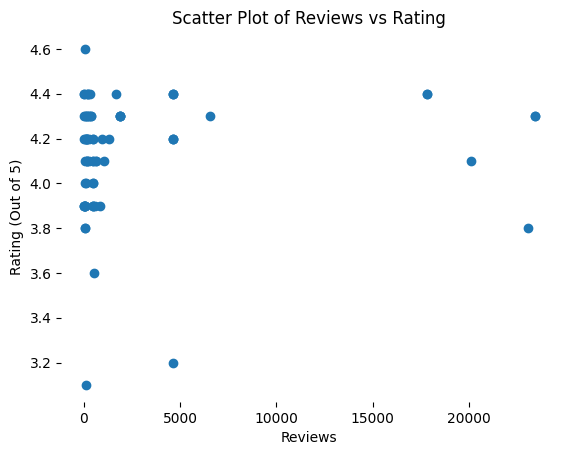

In [29]:
plt.scatter(x=df['Reviews'], y=df['Rating (Out of 5)'])
plt.xlabel('Reviews')
plt.ylabel('Rating (Out of 5)')
plt.title('Scatter Plot of Reviews vs Rating')
sns.despine(bottom = True,left = True)
plt.show()

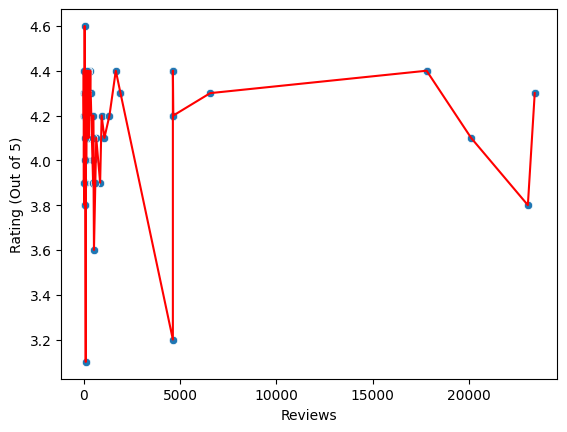

In [30]:
sns.scatterplot(data=df, x='Reviews', y='Rating (Out of 5)')
sns.lineplot(data=df, x='Reviews', y='Rating (Out of 5)', estimator=None, color='red')
plt.xlabel('Reviews')
plt.ylabel('Rating (Out of 5)')
plt.show()

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>There is no apparent clear relation between number of reviews and rating

Text(0.5, 1.0, 'Scatter Plot of Reviews vs Rating with Regression Line')

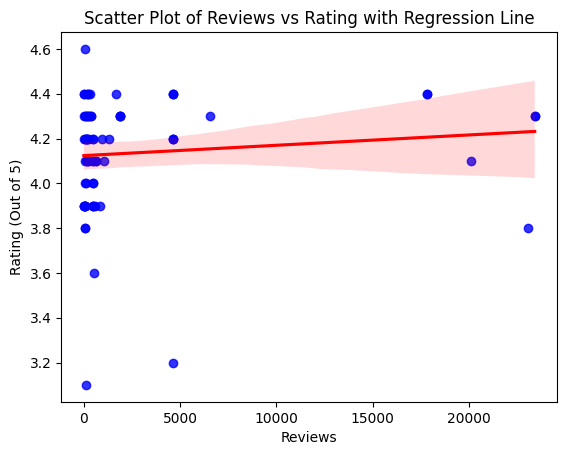

In [31]:
sns.regplot(data=df[df['Reviews']!=0], x='Reviews', y='Rating (Out of 5)', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.xlabel('Reviews')
plt.ylabel('Rating (Out of 5)')
plt.title('Scatter Plot of Reviews vs Rating with Regression Line')

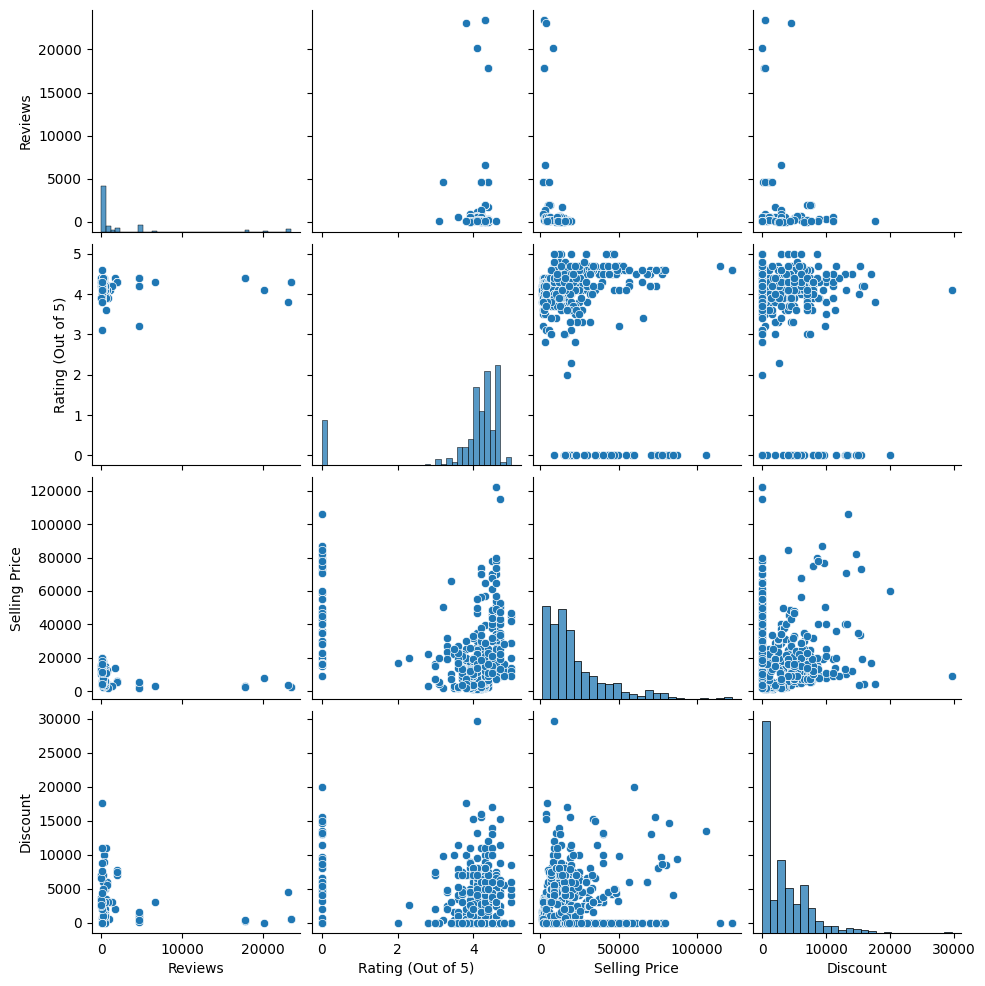

In [32]:
sns.pairplot(df[['Reviews', 'Rating (Out of 5)', 'Selling Price', 'Discount']])

In [34]:
# Drop rows with NaN or Inf in X or y
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Reviews', 'Rating (Out of 5)'])

X = df_clean[['Reviews']]
X = sm.add_constant(X)
y = df_clean['Rating (Out of 5)']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rating (Out of 5)   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8000
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.374
Time:                        15:53:31   Log-Likelihood:                -2.6045
No. Observations:                  77   AIC:                             9.209
Df Residuals:                      75   BIC:                             13.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1237      0.032    130.548      0.0

In [37]:
d = df_clean[df_clean['Reviews']!=0]
X = d[['Reviews']]
X = sm.add_constant(X)
y = d['Rating (Out of 5)']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rating (Out of 5)   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8000
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.374
Time:                        15:55:02   Log-Likelihood:                -2.6045
No. Observations:                  77   AIC:                             9.209
Df Residuals:                      75   BIC:                             13.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1237      0.032    130.548      0.0

In [ ]:
# # Option 1: Drop rows with missing values
# df_cleaned = df.dropna()

# # Option 2: Impute missing values (e.g., fill with mean)
# # df_imputed = df.fillna(df.mean())

# # Replace infinite values with NaN
# df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Then, drop or impute missing values again
# df_cleaned = df_cleaned.dropna()

In [159]:
# Calculate the minimum value of the column
min_value = df['Discount'].min()

# Calculate the maximum value of the column
max_value = df['Discount'].max()

min_value

In [160]:
max_value

In [44]:
# Check for NaNs in the DataFrame
# print(df_cleaned.isnull().sum())

# Check for infinite values in the DataFrame
# print(np.isinf(df_cleaned).sum())

df_cleaned['Selling Price'] = df_cleaned['Selling Price'].astype(str)
df_cleaned['Original Price'] = df_cleaned['Original Price'].astype(str)

In [161]:
# import pandas as pd
# from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoosting
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.inspection import permutation_importance
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define your treatment (e.g., 'Rating (Out of 5)') and outcome (e.g., 'Selling Price')
# treatment = 'Rating (Out of 5)'
# outcome = 'Selling Price'

# # One-hot encode categorical variables
# df_encoded = pd.get_dummies(df, drop_first=True)

# # Prepare the data
# X = df_encoded.drop(columns=[outcome])
# y = df_encoded[outcome].astype(float)

# # Train a HistGradientBoostingRegressor
# model = HistGradientBoostingRegressor(random_state=42)
# model.fit(X, y)

# # Calculate permutation importance
# result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)

# # Get feature importances
# importances = result.importances_mean
# feature_names = X.columns
# feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# # Sort by importance
# feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance_df)
# plt.title('Permutation Feature Importance for Predicting Selling Price')
# plt.show()

In [47]:
# Convert the necessary columns to numeric
df_cleaned['Selling Price'] = df_cleaned['Selling Price'].str.replace(',', '').astype(float)
df_cleaned['Rating (Out of 5)'] = df_cleaned['Rating (Out of 5)'].astype(float)

# Calculate Discount as the difference between Original Price and Selling Price
df_cleaned['Discount'] = df_cleaned['Original Price'].str.replace(',', '').astype(float) - df_cleaned['Selling Price']

# Define a function to estimate the causal effect and refute the analysis
def causal_analysis(data, treatment, outcome, confounders=[]):
    causal_model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        common_causes=confounders
    )

    identified_estimand = causal_model.identify_effect()

    estimate = causal_model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )

    print(estimate)

# Test 1: Effect of Rating on Selling Price
causal_analysis(df_cleaned, treatment="Rating (Out of 5)", outcome="Selling Price", confounders=["Brand Name", "Strap Material"])

# Test 2: Effect of Selling Price on Discount
causal_analysis(df_cleaned, treatment="Selling Price", outcome="Discount", confounders=["Brand Name", "Strap Material"])

# Test 3: Effect of Rating on Discount
causal_analysis(df_cleaned, treatment="Rating (Out of 5)", outcome="Discount", confounders=["Brand Name", "Strap Material"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                      
────────────────────(E[Selling Price|Strap Material,Brand Name])
d[Rating (Out of 5)]                                            
Estimand assumption 1, Unconfoundedness: If U→{Rating (Out of 5)} and U→Selling Price then P(Selling Price|Rating (Out of 5),Strap Material,Brand Name,U) = P(Selling Price|Rating (Out of 5),Strap Material,Brand Name)

## Realized estimand
b: Selling Price~Rating (Out of 5)+Strap Material+Brand Name
Target units: ate

## Estimate
Mean value: 2358.272562271626

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                               
────────────────(E[Discount|Strap Material,Brand Name])
d[Selling Price] 

In [48]:
# Test 1: Effect of Rating on Selling Price
causal_analysis(df_cleaned, treatment="Rating (Out of 5)", outcome="Selling Price", confounders=[])

# Test 2: Effect of Selling Price on Discount
causal_analysis(df_cleaned, treatment="Selling Price", outcome="Discount", confounders=[])

# Test 3: Effect of Rating on Discount
causal_analysis(df_cleaned, treatment="Rating (Out of 5)", outcome="Discount", confounders=[])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                            
────────────────────(E[Selling Price])
d[Rating (Out of 5)]                  
Estimand assumption 1, Unconfoundedness: If U→{Rating (Out of 5)} and U→Selling Price then P(Selling Price|Rating (Out of 5),,U) = P(Selling Price|Rating (Out of 5),)

## Realized estimand
b: Selling Price~Rating (Out of 5)
Target units: ate

## Estimate
Mean value: 734.2733084709553

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                     
────────────────(E[Discount])
d[Selling Price]             
Estimand assumption 1, Unconfoundedness: If U→{Selling Price} and U→Discount then P(Discount|Selling Price,,U) = P(Discount|Selling Price,)

## Realized estimand
b: Discount~Selling Price
Targe

In [50]:
# Calculate Discount as the difference between Original Price and Selling Price
# df['Discount'] = df['Original Price'].str.replace(',', '').astype(float) - df['Selling Price'].str.replace(',', '').astype(float)

def causal_analysis(df, treatment, outcome, confounders=[]):
    causal_model = CausalModel(
    data=df,
    treatment="Rating (Out of 5)",
    outcome="Selling Price",
    common_causes=["Brand Name", "Strap Material"]  # Add potential confounders here
)

    identified_estimand = causal_model.identify_effect()

    estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"  # Use linear regression instead of propensity scores
    )
    print(estimate)

# Test 1: Effect of Rating on Selling Price
# causal_analysis(df, treatment="Rating (Out of 5)", outcome="Selling Price")

# Test 2: Effect of Selling Price on Discount
causal_analysis(df, treatment="Selling Price", outcome="Discount")

# Test 3: Effect of Rating on Discount
# causal_analysis(df, treatment="Rating (Out of 5)", outcome="Discount")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                      
────────────────────(E[Selling Price|Strap Material,Brand Name])
d[Rating (Out of 5)]                                            
Estimand assumption 1, Unconfoundedness: If U→{Rating (Out of 5)} and U→Selling Price then P(Selling Price|Rating (Out of 5),Strap Material,Brand Name,U) = P(Selling Price|Rating (Out of 5),Strap Material,Brand Name)

## Realized estimand
b: Selling Price~Rating (Out of 5)+Strap Material+Brand Name
Target units: ate

## Estimate
Mean value: -2482.069575751724



In [51]:
df[~df['Reviews'].isna()].groupby('Brand Name')['Reviews'].count()

Brand Name
FOSSIL     15
Honor      20
Oppo        1
Xiaomi      2
boAt        4
huami      32
realme      3
Name: Reviews, dtype: int64

In [52]:
df.head().T

0  \
Brand Name                                          Xiaomi   
Device Type                                    FitnessBand   
Model Name                                    Smart Band 5   
Color                                                Black   
Selling Price                                       2499.0   
Original Price                                      2999.0   
Display                                     AMOLED Display   
Rating (Out of 5)                                      4.1   
Strap Material                  Thermoplastic polyurethane   
Average Battery Life (in days)                          14   
Reviews                                                NaN   
Discount                                             500.0   

                                                         1            2  \
Brand Name                                          Xiaomi       Xiaomi   
Device Type                                    FitnessBand  FitnessBand   
Model Name                                    Smart Band 4     HMSH01GE   
Color                                                Black        Black   
Selling Price                                       2099.0       1722.0   
Original Price                                      2499.0       2099.0   
Display                                     AMOLED Display  LCD Display   
Rating (Out of 5)                                      4.2          3.5   
Strap Material                  Thermoplastic polyurethane      Leather   
Average Battery Life (in days)                          14           14   
Reviews                                                NaN          NaN   
Discount                                             400.0        377.0   

                                                         3             4  
Brand Name                                          Xiaomi        Xiaomi  
Device Type                                    FitnessBand   FitnessBand  
Model Name                                    Smart Band 5        Band 3  
Color                                                Black         Black  
Selling Price                                       2469.0        1799.0  
Original Price                                      2999.0        2199.0  
Display                                     AMOLED Display  OLED Display  
Rating (Out of 5)                                      4.1           4.3  
Strap Material                  Thermoplastic polyurethane       Plastic  
Average Battery Life (in days)                          14             7  
Reviews                                                NaN           NaN  
Discount                                             530.0         400.0

# Data Cleaning

In [53]:
df['Brand Name'].unique()

array(['Xiaomi', 'OnePlus ', 'FitBit', 'realme', 'Huawei', 'Honor',
       'GOQii', 'Infinix', 'LCARE', 'LAVA', 'Noise', 'Oppo', 'Fastrack',
       'boAt ', 'Noise ', 'huami', 'SAMSUNG ', 'FOSSIL ', 'APPLE',
       'GARMIN '], dtype=object)

In [54]:
df[~df['Reviews'].isna()]['Brand Name'].unique()

array(['Xiaomi', 'Honor', 'Oppo', 'realme', 'boAt ', 'huami', 'FOSSIL '],
      dtype=object)

In [55]:
df['Brand Name'] = df['Brand Name'].str.strip().str.capitalize()

<Axes: >

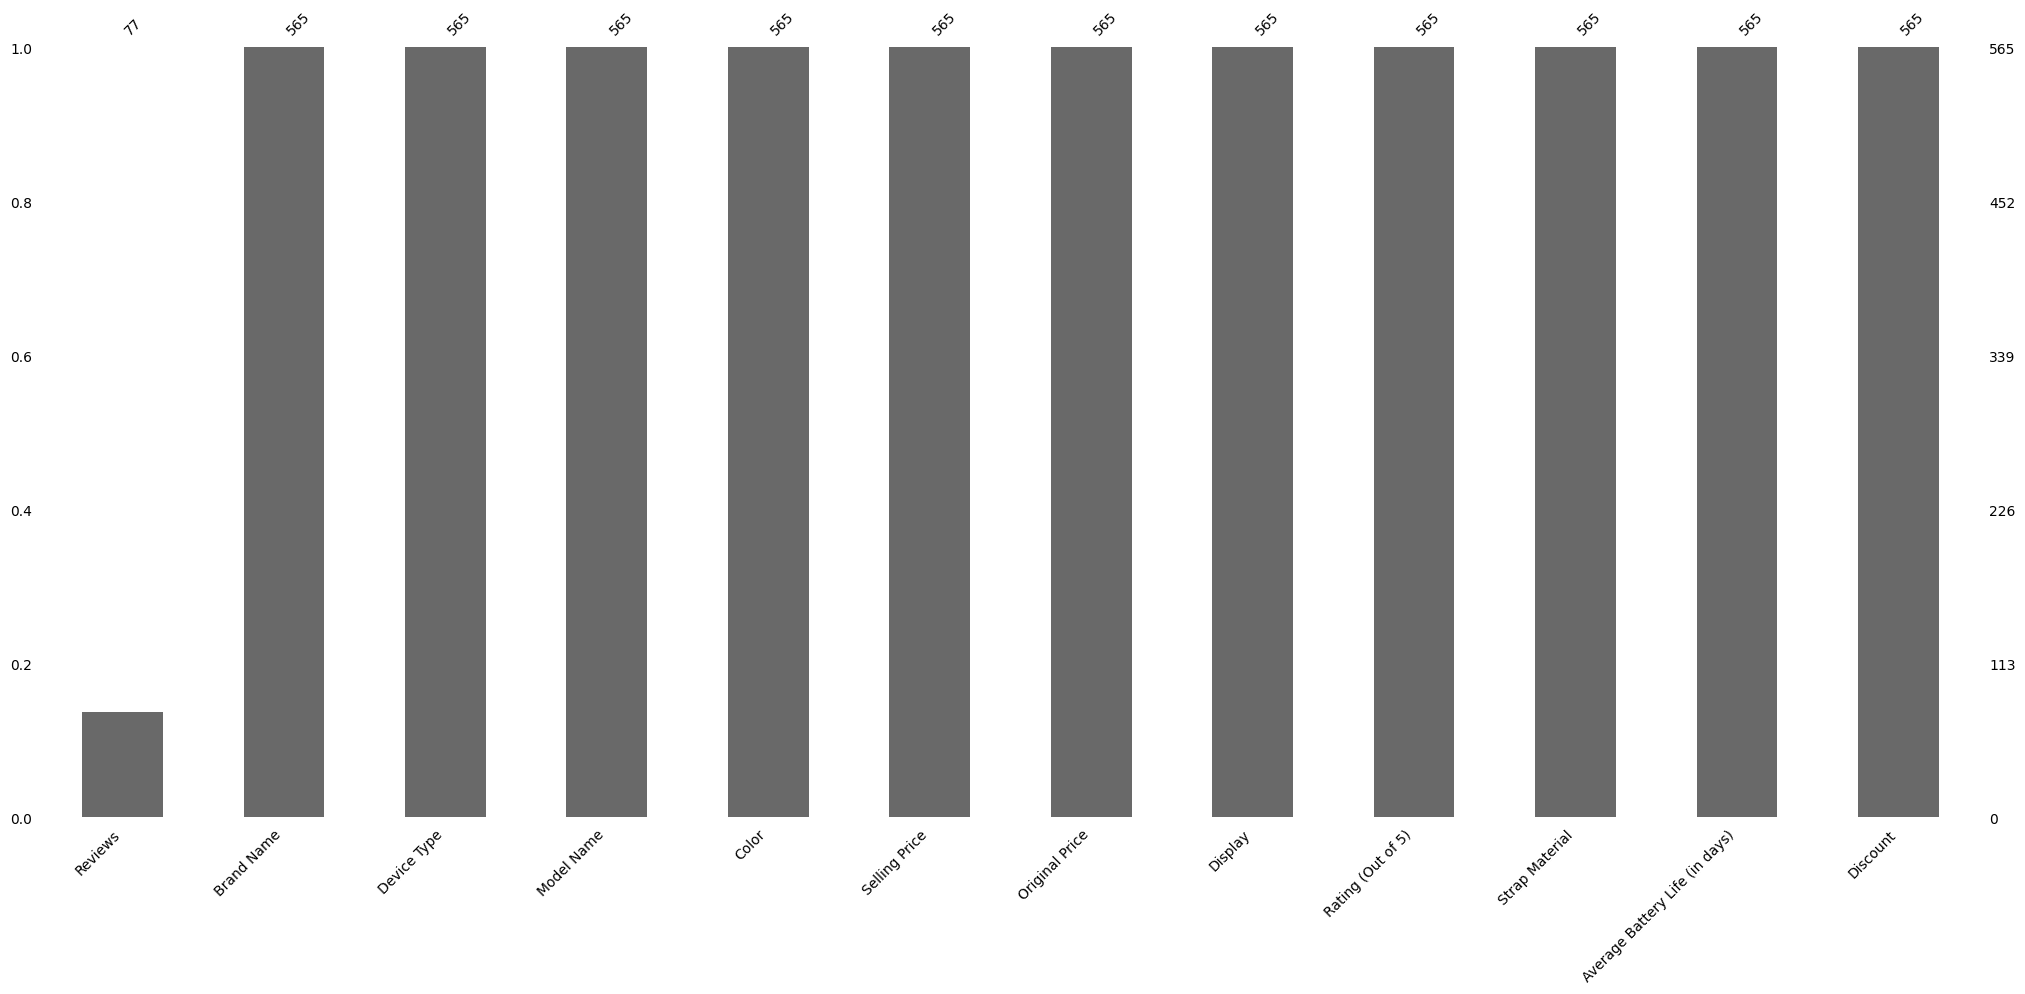

In [56]:
ms.bar(df,fontsize = 10 ,sort="ascending")

In [57]:
df['Rating (Out of 5)'].isna().sum()

0

In [58]:
df[df['Rating (Out of 5)'].isna()]

# All null values are for Garmin Smartwatches

Empty DataFrame
Columns: [Brand Name, Device Type, Model Name, Color, Selling Price, Original Price, Display, Rating (Out of 5), Strap Material, Average Battery Life (in days), Reviews, Discount]
Index: []

In [59]:
df['Rating (Out of 5)'].fillna(0,inplace=True)

In [60]:
df['Rating (Out of 5)'].isna().sum()

0

In [61]:
df['Original Price'].dtype

dtype('float64')

In [62]:
df['Original Price']

0       2999.0
1       2499.0
2       2099.0
3       2999.0
4       2199.0
        ...   
560    55000.0
561    20990.0
562     1999.0
563     3499.0
564    18495.0
Name: Original Price, Length: 565, dtype: float64

In [64]:
df['Original Price'].describe()

count       565.000000
mean      25365.361062
std       20384.028759
min        1599.000000
25%       12999.000000
50%       19995.000000
75%       32900.000000
max      122090.000000
Name: Original Price, dtype: float64

In [65]:
df['Selling Price'].describe()

count       565.000000
mean      22110.373451
std       19914.926066
min        1195.000000
25%        8990.000000
50%       15995.000000
75%       29900.000000
max      122090.000000
Name: Selling Price, dtype: float64

In [66]:
round(df.describe().T,2)

count      mean       std     min      25%  \
Selling Price                   565.0  22110.37  19914.93  1195.0   8990.0   
Original Price                  565.0  25365.36  20384.03  1599.0  12999.0   
Rating (Out of 5)               565.0      3.85      1.27     0.0      3.9   
Average Battery Life (in days)  565.0      9.03      7.87     1.0      2.0   
Reviews                          77.0   2471.53   5641.09     2.0    103.0   
Discount                        565.0   3254.99   3800.38     0.0      0.0   

                                    50%      75%       max  
Selling Price                   15995.0  29900.0  122090.0  
Original Price                  19995.0  32900.0  122090.0  
Rating (Out of 5)                   4.2      4.5       5.0  
Average Battery Life (in days)      7.0     14.0      45.0  
Reviews                           338.0   1334.0   23426.0  
Discount                         2500.0   5000.0   29693.0

# EDA

In [67]:
print("Number of Brands : ",df['Brand Name'].nunique())
df['Brand Name'].unique()

Number of Brands :  19


array(['Xiaomi', 'Oneplus', 'Fitbit', 'Realme', 'Huawei', 'Honor',
       'Goqii', 'Infinix', 'Lcare', 'Lava', 'Noise', 'Oppo', 'Fastrack',
       'Boat', 'Huami', 'Samsung', 'Fossil', 'Apple', 'Garmin'],
      dtype=object)

In [174]:
# df.groupby('Brand Name')['Model Name'].value_counts()

df.groupby('Device Type')['Model Name'].count()

Device Type
FitnessBand     75
Smartwatch     490
Name: Model Name, dtype: int64

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>490 smartwatches and 75 fitnessbands from 19 different brands indicate that there is a good demand for Fitness Trackers in the current scenario.</centre></strong></h3>

In [68]:
df['Display'].unique()

array(['AMOLED Display', 'LCD Display', 'OLED Display', 'PMOLED Display',
       'LED Display', 'TFT-LCD Display', 'OLED Retina Display'],
      dtype=object)

In [69]:
device_type_counts = df['Device Type'].value_counts()
px.pie(df,values = device_type_counts.values,names = device_type_counts.index,labels={"label":"Device Type","value":"Count"},title='Device Type Count',hole=0.6,width=500,height=500)

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>86.7% of the devices are Fitness Bands

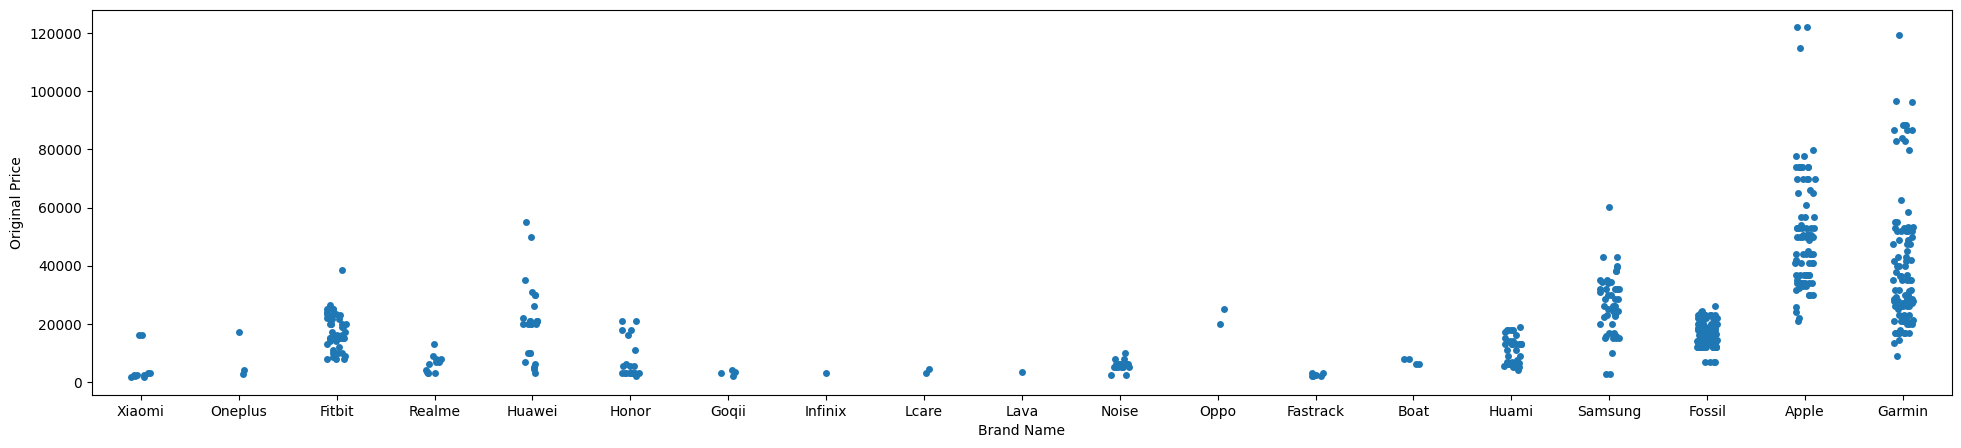

In [70]:
fig, ax = plt.subplots(figsize=(24,5))
ax = sns.stripplot(data = df, x = "Brand Name", y = "Original Price")

In [71]:
df[df['Brand Name'].isin(['Huami','Fossil'])].groupby('Brand Name')['Selling Price'].agg(['min','std','max'])

min          std      max
Brand Name                              
Fossil      3799.0  5031.256507  25995.0
Huami       1999.0  3475.392000  13999.0

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>Fossil and Huami selling price remains is relatively bunched around

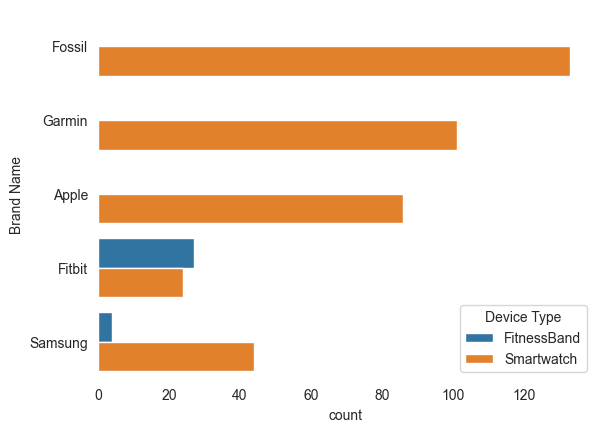

In [178]:
sns.countplot(y="Brand Name", hue="Device Type", data=df,
              order=df["Brand Name"].value_counts().iloc[:5].index)
sns.despine(bottom = True,left = True)

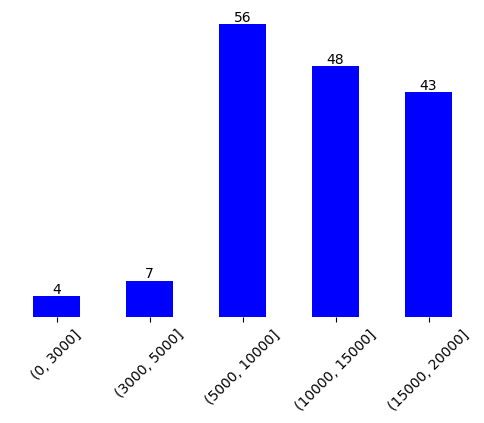

In [72]:
out = pd.cut(x = df.loc[df['Brand Name'].isin(['Huami','Fossil']),'Selling Price'],bins = [0,3000,5000,10000,15000,20000])
ax = out.value_counts(sort=False).plot.bar(rot=45, color="b", figsize=(6,4))
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
ax.set_yticks([])
sns.despine(bottom = True, left = True)
plt.show()

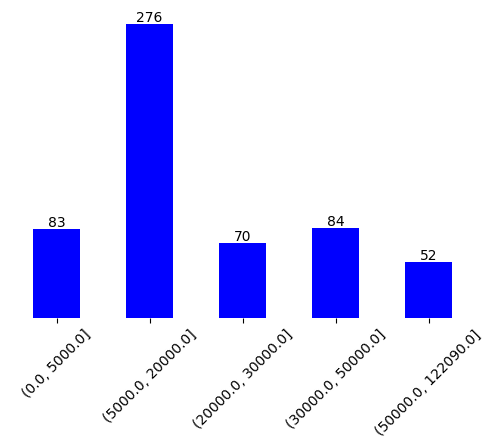

In [73]:
out = pd.cut(x = df['Selling Price'],bins = [0,5000,20000,30000,50000,df['Selling Price'].max()])
ax = out.value_counts(sort=False).plot.bar(rot=45, color="b", figsize=(6,4))
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
ax.set_yticks([])
sns.despine(bottom = True, left = True)
plt.show()

In [74]:
bins = [5000, 8000, 10000, 12000, 15000]
labels = ['5-8k', '8-10k', '10-12k', '12-15k']

pd.cut(df['Selling Price'], bins=bins, labels=labels, include_lowest=True).value_counts()

12-15k    56
5-8k      53
8-10k     41
10-12k    31
Name: Selling Price, dtype: int64

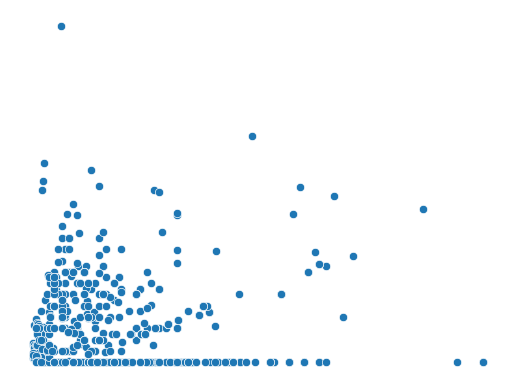

In [75]:
sns.scatterplot(data = df, x = 'Selling Price', y = 'Discount')
sns.despine(bottom = True, left = True)
plt.axis('off')
plt.show()

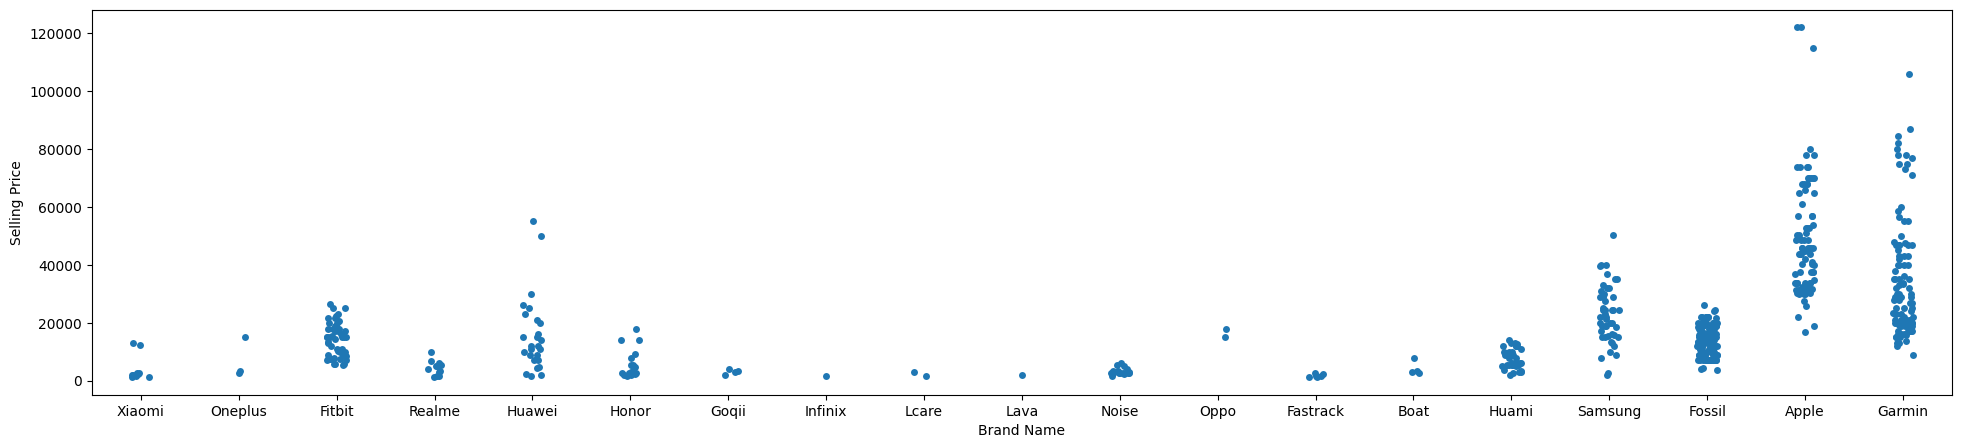

In [76]:
fig, ax = plt.subplots(figsize=(24,5))
ax = sns.stripplot(data = df, x = "Brand Name", y = "Selling Price")

In [77]:
px.box(data_frame = df, x = 'Brand Name', y = 'Average Battery Life (in days)') 

In [78]:
df[df['Brand Name']=='Garmin']['Average Battery Life (in days)'].agg(['mean','std','min','max'])

mean    16.960396
std     10.416257
min      5.000000
max     45.000000
Name: Average Battery Life (in days), dtype: float64

In [79]:
df[df['Brand Name']=='Huami']['Average Battery Life (in days)'].agg(['mean','std','min','max'])

mean    16.055556
std      7.297532
min      5.000000
max     28.000000
Name: Average Battery Life (in days), dtype: float64

In [80]:
px.box(df[df['Brand Name'].isin(['Xiaomi','Honor','Samsung','Garmin'])], x = 'Average Battery Life (in days)' ,y = 'Brand Name')

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre>Garmin,Samsung and Fossil brands are expensive but do not have comparable battery life. While Xiaomi being on the cheaper side has better battery life than Apple. This could imply that generally higher price does not mean better battery life for the fitness tracker.</centre></strong></h3>

#### Number of bands with battery life greater than the average and their Original, Selling Price

In [179]:
df[df['Average Battery Life (in days)']>=df['Average Battery Life (in days)'].mean()].agg({'Brand Name':'count','Selling Price':'mean','Original Price':'mean'}).round(2).rename({'Brand Name':'Count'})

Count               236.00
Selling Price     22804.98
Original Price    26771.30
dtype: float64

#### Products with Selling Price higher than the average Selling Price

In [82]:
df[df['Selling Price']>df['Selling Price'].mean()]['Brand Name'].value_counts()

Apple      83
Garmin     63
Samsung    23
Huawei      6
Fitbit      5
Fossil      3
Name: Brand Name, dtype: int64

#### Products with Ratings higher than the average and their average min,max and average price

In [83]:
df[df['Rating (Out of 5)']>df['Rating (Out of 5)'].mean()]['Selling Price'].agg(['min','max','mean']).round(2)

min       1195.00
max     122090.00
mean     20727.15
Name: Selling Price, dtype: float64

In [84]:
df[(df['Rating (Out of 5)']>df['Rating (Out of 5)'].mean()) & (df['Selling Price'] == 1195)]

Brand Name  Device Type         Model Name        Color  Selling Price  \
108   Fastrack  FitnessBand  Reflex Smart Band  Green, Grey         1195.0   

     Original Price       Display  Rating (Out of 5) Strap Material  \
108          1995.0  OLED Display                4.1       Silicone   

     Average Battery Life (in days)  Reviews  Discount  
108                               4      NaN     800.0

<h3 style="font-family: sans-serif MS;background-color:#bde0fe;color:#7c3a5f;text-align: center;padding-top: 20px;padding-bottom: 20px;border-radius: 5px 15px;letter-spacing: 0.5px;"><strong><centre> Fasttrack is the brand with rating greater than the mean having the least selling price 

In [85]:
df[(df['Rating (Out of 5)']>df['Rating (Out of 5)'].mean())].groupby('Brand Name')['Model Name'].count()

Brand Name
Apple        85
Boat          2
Fastrack      5
Fitbit       46
Fossil      116
Garmin       33
Honor        18
Huami        35
Huawei       22
Noise        18
Oneplus       3
Oppo          2
Realme       12
Samsung      42
Xiaomi        9
Name: Model Name, dtype: int64

In [86]:
df[df['Rating (Out of 5)']>df['Rating (Out of 5)'].mean()].groupby('Device Type')['Device Type'].value_counts()

Device Type  Device Type
FitnessBand  FitnessBand     62
Smartwatch   Smartwatch     386
Name: Device Type, dtype: int64

In [87]:
df[df['Rating (Out of 5)']>df['Rating (Out of 5)'].mean()][['Selling Price','Brand Name']].value_counts().sort_index()[0:20]

Selling Price  Brand Name
1195.0         Fastrack      1
1270.0         Xiaomi        1
1290.0         Realme        1
1299.0         Xiaomi        1
1395.0         Fastrack      1
1450.0         Realme        1
1499.0         Realme        1
1595.0         Fastrack      1
1645.0         Fastrack      1
1699.0         Huawei        1
               Noise         1
1799.0         Honor         1
               Xiaomi        1
1899.0         Huawei        1
1999.0         Huami         1
2099.0         Honor         1
               Xiaomi        1
2199.0         Honor         1
               Huawei        1
2200.0         Fastrack      1
dtype: int64

In [88]:
df_color_count = df.groupby('Brand Name').aggregate({'Color':'count','Rating (Out of 5)':'mean'}).sort_values('Rating (Out of 5)',ascending=False)

In [89]:
df_color_count

Color  Rating (Out of 5)
Brand Name                          
Apple          86           4.545349
Oneplus         3           4.300000
Fossil        133           4.244361
Samsung        48           4.229167
Honor          20           4.195000
Fitbit         51           4.186275
Xiaomi         10           4.170000
Huawei         26           4.161538
Huami          36           4.152778
Realme         12           4.141667
Noise          19           4.026316
Fastrack        6           4.016667
Boat            4           3.900000
Oppo            2           3.900000
Infinix         1           3.800000
Lcare           2           3.650000
Lava            1           3.600000
Goqii           4           3.350000
Garmin        101           2.022772

In [90]:
stats.pearsonr (df_color_count['Rating (Out of 5)'],df_color_count['Color'])

PearsonRResult(statistic=-0.11796415841453389, pvalue=0.6305371175639954)

In [91]:
stats.spearmanr (df_color_count['Rating (Out of 5)'],df_color_count['Color'])

SignificanceResult(statistic=0.5131812174649342, pvalue=0.024634457627041317)

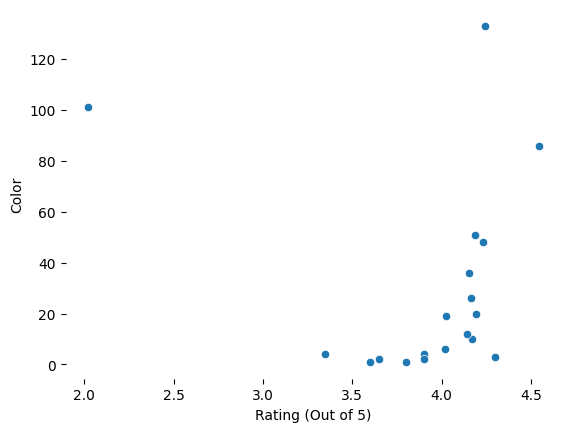

In [92]:
sns.scatterplot(data = df_color_count, x = 'Rating (Out of 5)', y = 'Color')
sns.despine(bottom = True,left = True)

In [93]:
df_color_sellingprice = df.groupby('Brand Name').aggregate({'Color':'count','Selling Price':'mean'}).sort_values('Selling Price',ascending=False)

In [94]:
stats.pearsonr (df_color_sellingprice['Selling Price'],df_color_count['Color'])

PearsonRResult(statistic=0.43331708059464963, pvalue=0.06383728604992281)

In [95]:
stats.spearmanr(df_color_sellingprice['Selling Price'],df_color_count['Color'])

SignificanceResult(statistic=0.5155911370027484, pvalue=0.023855077172569083)

In [96]:
df.groupby('Model Name')['Color'].count().sort_values(ascending=False)

Model Name
Charge 2                           8
Gen 5 Julianna HR                  6
Band 2                             5
Amazfit Bip                        5
Jacqueline Hybrid                  5
                                  ..
Forerunner 245                     1
Forerunner 235 Activity Tracker    1
Flex Small                         1
Fit Evolve                         1
vivoactive 4S 40mm                 1
Name: Color, Length: 384, dtype: int64

In [97]:
df[df['Brand Name']=='Apple']['Model Name'].value_counts()

SE GPS + Cellular 40 mm Gold Aluminium Case                3
SE GPS + Cellular 44 mm Gold Aluminium Case                3
8 mm Stainless Steel Case                                  2
Series 6 GPS + Cellular 40 mm Gold Stainless Steel Case    2
Series 6 GPS 44 mm Blue Aluminium Case                     2
                                                          ..
Series 5 GPS 40 mm Silver Aluminium Case                   1
Series 7 GPS 45 mm                                         1
SE 44 mm Space Grey Aluminium Case                         1
Series 7 GPS + Cellular 41 mm Aluminium                    1
Nike+ - 38 mm Space Gray Aluminium Case                    1
Name: Model Name, Length: 71, dtype: int64

In [98]:
df_apple_products = df[(df['Brand Name']=='Apple') & (df['Model Name'].str.contains('Series'))][['Model Name','Color']]

In [99]:
df_apple_products.groupby('Model Name')['Color'].nunique()

Model Name
Nike Series 5 GPS + Cellular 44 mm                                1
Series 1 - 38 mm Silver Aluminium Case                            1
Series 1 - 42 mm Gold Aluminium Case                              1
Series 2 - 38 mm Stainless Steel Case                             1
Series 2 - 42 mm Space Black Stainless Steel Case                 1
Series 2 - 42 mm Stainless Steel Case                             1
Series 3 GPS + Cellular- 42 mm Gray Ceramic Case                  1
Series 3 GPS + Cellular- 42 mm White Ceramic Case                 1
Series 3 GPS - 38 mm Space Grey Aluminium Case                    1
Series 3 GPS - 42 mm Space Grey Aluminium Case                    1
Series 5 GPS + Cellular 40 mm Space Black Stainless Steel Case    1
Series 5 GPS + Cellular 40 mm Space Grey Aluminium Case           1
Series 5 GPS + Cellular 40 mm Stainless Steel Case                1
Series 5 GPS + Cellular 44 mm Gold Aluminium Case                 1
Series 5 GPS + Cellular 44 mm Gold St

In [100]:
df['Model Name'].nunique()

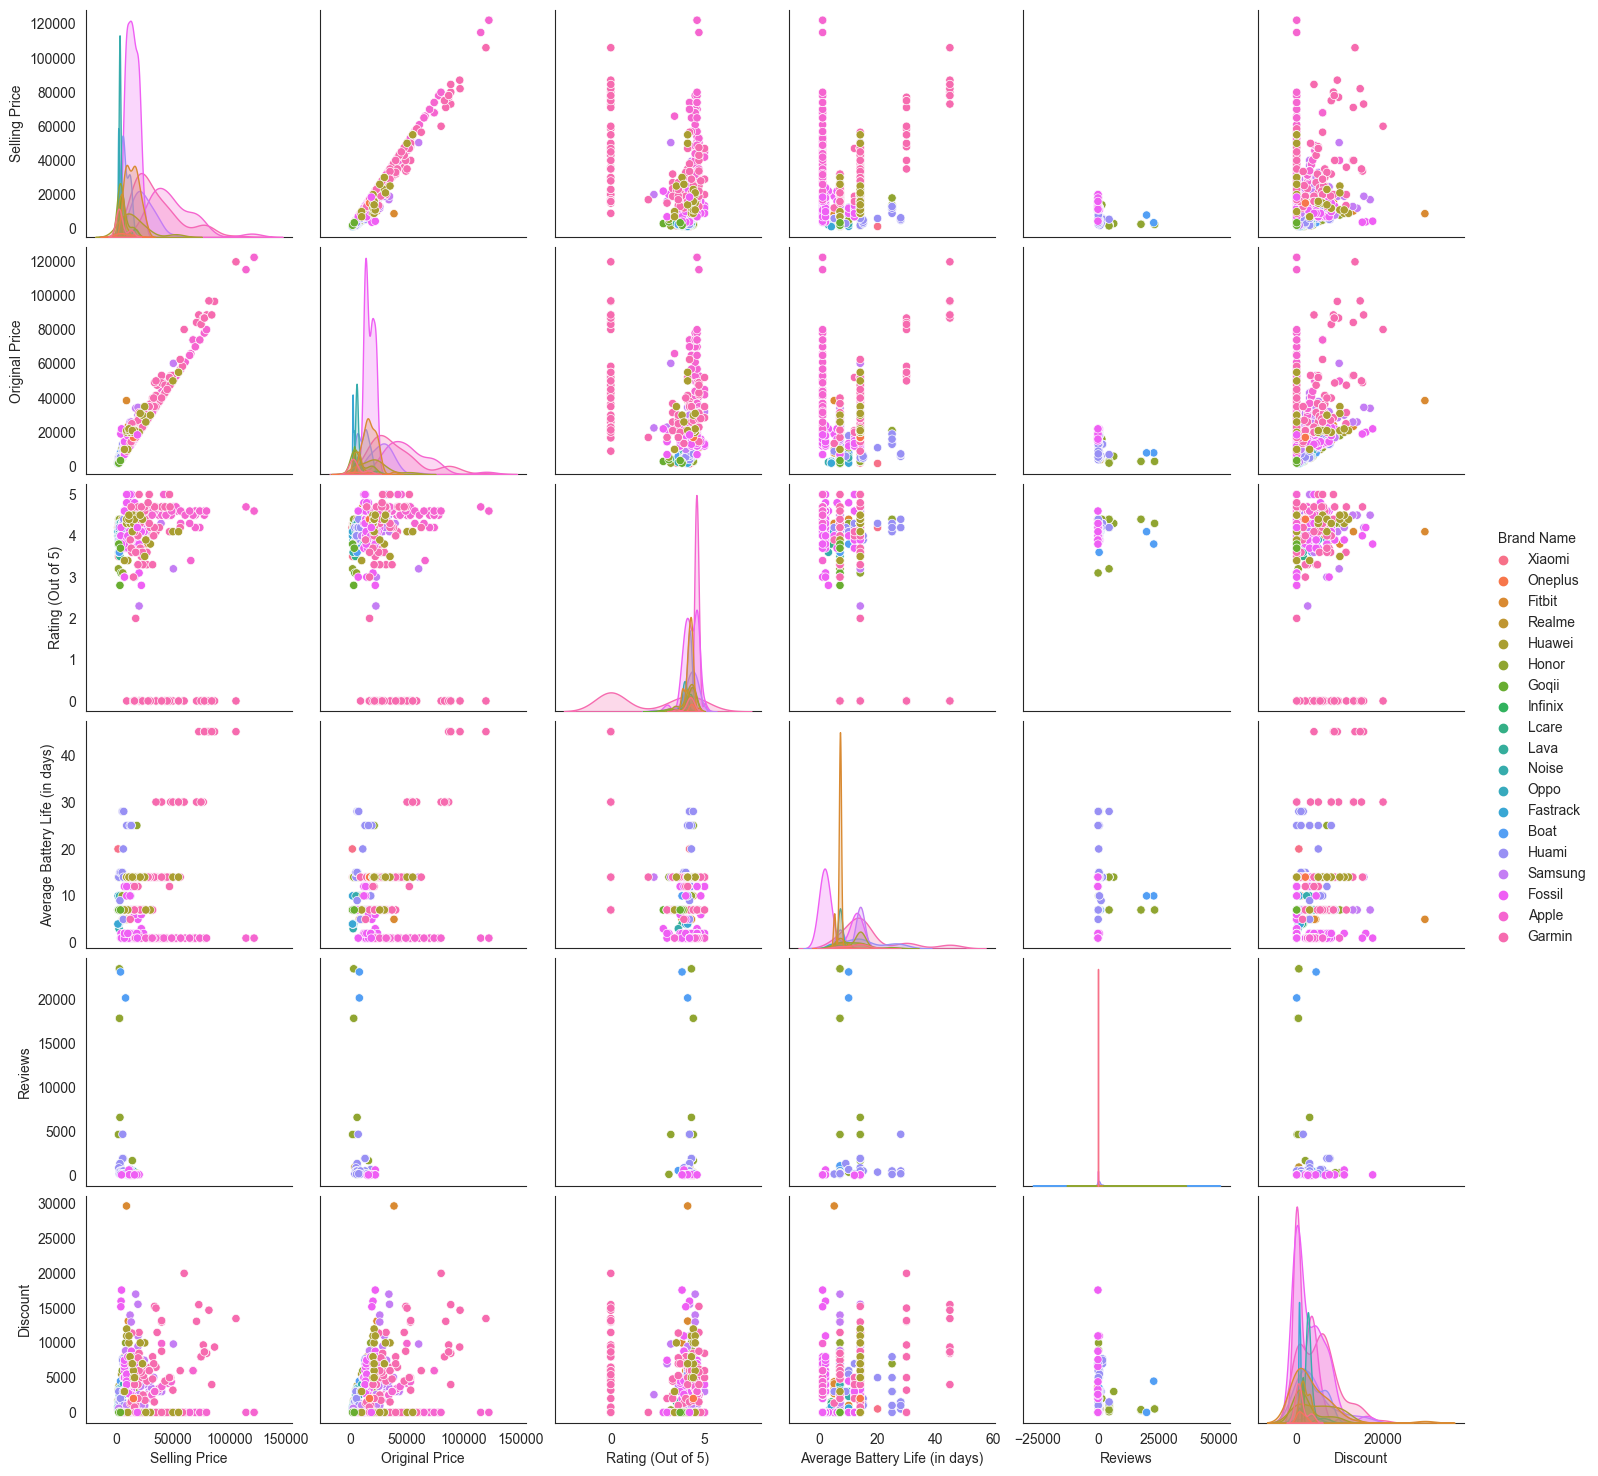

In [101]:
sns.set_style("white")
sns.pairplot(df, hue='Brand Name')

In [ ]:
# px.bar(y = df['Strap Material'],color=df['Device Type'],template='ggplot2')

<Axes: xlabel='count', ylabel='Strap Material'>

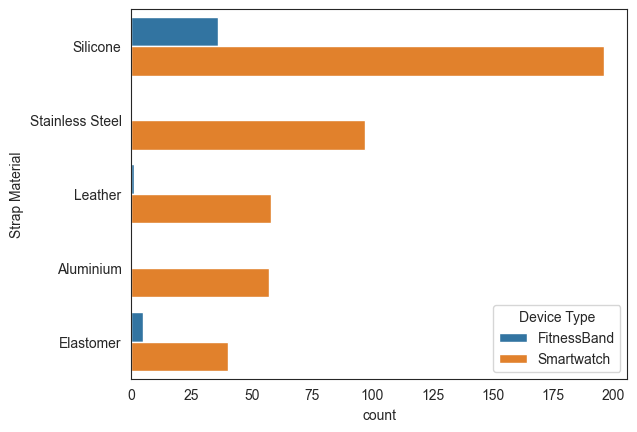

In [102]:
sns.countplot(y="Strap Material", hue="Device Type", data=df, 
              order=df["Strap Material"].value_counts().iloc[:5].index)

In [103]:
df[df['Selling Price']==df['Selling Price'].max()]

Brand Name Device Type                                         Model Name  \
430      Apple  Smartwatch   Series 3 GPS + Cellular- 42 mm Gray Ceramic Case   
435      Apple  Smartwatch  Series 3 GPS + Cellular- 42 mm White Ceramic Case   

     Color  Selling Price  Original Price              Display  \
430  Black       122090.0        122090.0  OLED Retina Display   
435  Black       122090.0        122090.0  OLED Retina Display   

     Rating (Out of 5) Strap Material  Average Battery Life (in days)  \
430                4.6          Nylon                               1   
435                4.6          Nylon                               1   

     Reviews  Discount  
430      NaN       0.0  
435      NaN       0.0

In [104]:
df[df['Brand Name']=='Xiaomi']['Selling Price'].mean()

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


<Axes: >

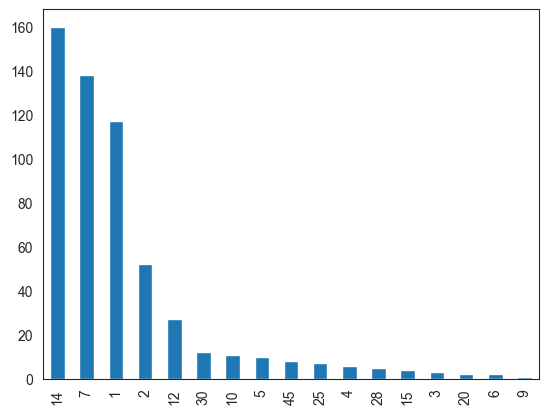

In [105]:
# df.plot.bar(x='Average Battery Life (in days)',y='Rating (Out of 5)')
df['Average Battery Life (in days)'].value_counts().sort_values(ascending = False).plot.bar()

In [106]:
df_avg_batt = round(df.groupby('Brand Name')['Average Battery Life (in days)'].mean()).sort_values(ascending=False)

In [107]:
fig = px.bar(x = df_avg_batt.index,y = df_avg_batt)                                   
fig.update_traces(marker=dict(color=['red' if x > df_avg_batt.mean() else 'grey' for x in df_avg_batt]))

<Axes: xlabel='Display'>

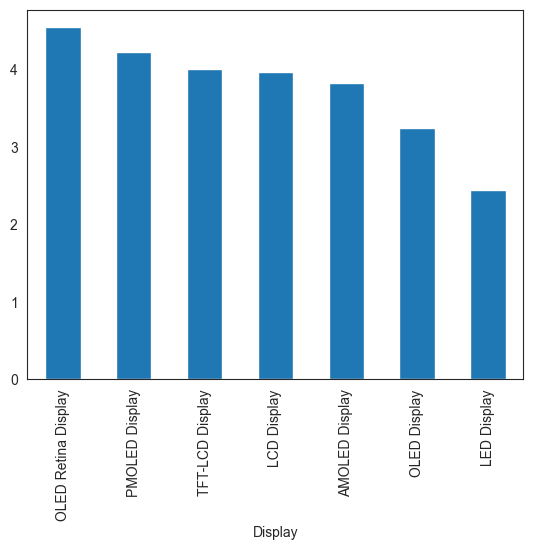

In [108]:
df.groupby(by = 'Display')['Rating (Out of 5)'].mean().sort_values(ascending = False).plot.bar()

In [109]:
df.groupby('Brand Name')['Selling Price'].mean().sort_values(ascending=False)

Brand Name
Apple       49413.837209
Garmin      35038.227723
Samsung     22901.375000
Oppo        16490.000000
Huawei      15874.615385
Fitbit      14018.843137
Fossil      13824.954887
Huami        7547.638889
Oneplus      6932.333333
Honor        5510.000000
Realme       4402.750000
Boat         4246.750000
Xiaomi       4100.400000
Noise        3183.947368
Goqii        3124.000000
Lcare        2347.000000
Lava         1999.000000
Fastrack     1754.166667
Infinix      1499.000000
Name: Selling Price, dtype: float64

<Axes: xlabel='Brand Name'>

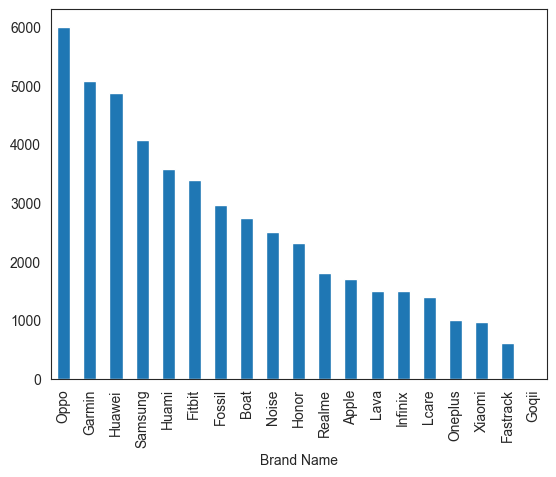

In [110]:
df.groupby('Brand Name')['Discount'].mean().sort_values(ascending = False).plot.bar()

In [111]:
dfg = df.groupby('Brand Name')[['Discount','Selling Price','Original Price']].agg({'Discount':['max','mean']})
dfg

Discount             
                max         mean
Brand Name                      
Apple        9910.0  1713.604651
Boat         4491.0  2743.250000
Fastrack      800.0   607.500000
Fitbit      29693.0  3390.705882
Fossil      17596.0  2959.812030
Garmin      20000.0  5082.702970
Goqii           0.0     0.000000
Honor       10000.0  2314.050000
Huami        8000.0  3573.083333
Huawei      12000.0  4876.923077
Infinix      1500.0  1500.000000
Lava         1500.0  1500.000000
Lcare        1500.0  1398.000000
Noise        4000.0  2499.263158
Oneplus      2000.0  1000.000000
Oppo         7000.0  6000.000000
Realme       3078.0  1804.583333
Samsung     17009.0  4079.395833
Xiaomi       3650.0   968.600000

AttributeError: 'Legend' object has no attribute 'legendHandles'

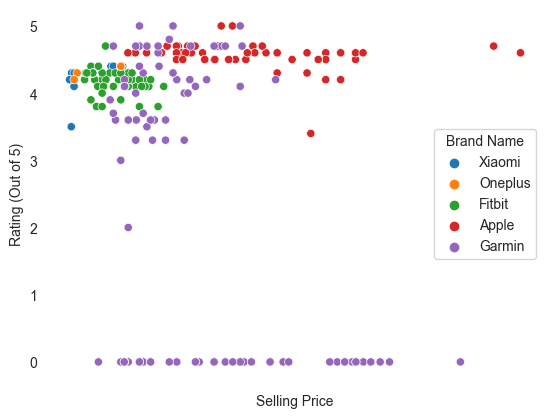

In [114]:
brand_list = ['Apple','Xiaomi','Oneplus','Fitbit','Garmin']
df2 = df[df['Brand Name'].isin(brand_list)]
ax = sns.scatterplot(data = df2, x = 'Selling Price', y = 'Rating (Out of 5)',hue = 'Brand Name')
sns.despine(bottom = True, left = True)
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.set(xticklabels=[]) # remove the tick labels (Tick labels joh niche plot ke selling price ki value hain voh remove karta hain)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [115]:
df.groupby(['Brand Name','Device Type'])[['Device Type','Brand Name']].count()

Device Type  Brand Name
Brand Name Device Type                         
Apple      Smartwatch            86          86
Boat       Smartwatch             4           4
Fastrack   FitnessBand            2           2
           Smartwatch             4           4
Fitbit     FitnessBand           27          27
           Smartwatch            24          24
Fossil     Smartwatch           133         133
Garmin     Smartwatch           101         101
Goqii      FitnessBand            4           4
Honor      FitnessBand           13          13
           Smartwatch             7           7
Huami      Smartwatch            36          36
Huawei     FitnessBand            6           6
           Smartwatch            20          20
Infinix    FitnessBand            1           1
Lava       FitnessBand            1           1
Lcare      FitnessBand            1           1
           Smartwatch             1           1
Noise      FitnessBand            2           2
           Smartwatch            17          17
Oneplus    FitnessBand            2           2
           Smartwatch             1           1
Oppo       Smartwatch             2           2
Realme     FitnessBand            4           4
           Smartwatch             8           8
Samsung    FitnessBand            4           4
           Smartwatch            44          44
Xiaomi     FitnessBand            8           8
           Smartwatch             2           2

In [116]:
df.groupby(['Brand Name','Device Type'])['Color'].count().reset_index().sort_values('Brand Name',ascending = True,key=lambda col: col.str.lower()).rename(columns={'Color':'Count'})

Brand Name  Device Type  Count
0       Apple   Smartwatch     86
1        Boat   Smartwatch      4
2    Fastrack  FitnessBand      2
3    Fastrack   Smartwatch      4
4      Fitbit  FitnessBand     27
5      Fitbit   Smartwatch     24
6      Fossil   Smartwatch    133
7      Garmin   Smartwatch    101
8       Goqii  FitnessBand      4
9       Honor  FitnessBand     13
10      Honor   Smartwatch      7
11      Huami   Smartwatch     36
12     Huawei  FitnessBand      6
13     Huawei   Smartwatch     20
14    Infinix  FitnessBand      1
15       Lava  FitnessBand      1
16      Lcare  FitnessBand      1
17      Lcare   Smartwatch      1
18      Noise  FitnessBand      2
19      Noise   Smartwatch     17
20    Oneplus  FitnessBand      2
21    Oneplus   Smartwatch      1
22       Oppo   Smartwatch      2
23     Realme  FitnessBand      4
24     Realme   Smartwatch      8
25    Samsung  FitnessBand      4
26    Samsung   Smartwatch     44
27     Xiaomi  FitnessBand      8
28     Xiaomi   Smartwatch      2

In [117]:
df.groupby('Brand Name')['Rating (Out of 5)'].mean().sort_values(ascending = False)

Brand Name
Apple       4.545349
Oneplus     4.300000
Fossil      4.244361
Samsung     4.229167
Honor       4.195000
Fitbit      4.186275
Xiaomi      4.170000
Huawei      4.161538
Huami       4.152778
Realme      4.141667
Noise       4.026316
Fastrack    4.016667
Boat        3.900000
Oppo        3.900000
Infinix     3.800000
Lcare       3.650000
Lava        3.600000
Goqii       3.350000
Garmin      2.022772
Name: Rating (Out of 5), dtype: float64

In [118]:
# corr = np.corrcoef(df['Average Battery Life (in days)'],df['Selling Price'])
# corr
# plt.figure(figsize=(10,8), dpi =500)
# sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
# plt.show()

corr, p_val = stats.pearsonr (df['Average Battery Life (in days)'],df['Selling Price'])
print(corr,p_val)

0.14202948202905324 0.0007099588570707717


Selling Price and Battery Life are positively correlated which suggests that higher priced smartbands and watches have better overall battery life

At first glance it looks correct but the data is skewed as there are more smartwathces (490)in the dataset as compared to fitness bands (75)

Another consideration is that Fitness bands have an average price of 5479.21 and while Smart Watches have an average price of 24655.96

In [119]:
print("Average Price for Fitness Band : " ,round(df[df['Device Type'] == 'FitnessBand']['Selling Price'].mean(),2))
print("Average Price for Smart Watch : " ,round(df[df['Device Type'] == 'Smartwatch']['Selling Price'].mean(),2))

Average Price for Fitness Band :  5479.21
Average Price for Smart Watch :  24655.96


In [120]:
df[df['Average Battery Life (in days)']==df['Average Battery Life (in days)'].max()]

Brand Name Device Type                 Model Name               Color  \
455     Garmin  Smartwatch          Fenix 6 Pro Solar         Grey, Black   
456     Garmin  Smartwatch                   Fenix 6X  Black, Orange, Red   
463     Garmin  Smartwatch             Fenix 6X Solar         Black, Grey   
464     Garmin  Smartwatch                    Fenix 6          Grey, Blue   
481     Garmin  Smartwatch                   Fenix 6X        Bluw, White    
491     Garmin  Smartwatch  Fenix 6 Sapphire Titanium       Blue Sapphire   
499     Garmin  Smartwatch                   Fenix 6S        Black, White   
504     Garmin  Smartwatch          Fenix 6 Pro Solar              Yellow   

     Selling Price  Original Price         Display  Rating (Out of 5)  \
455        72990.0         88490.0  AMOLED Display                0.0   
456        79990.0         88490.0  AMOLED Display                0.0   
463       105990.0        119490.0  AMOLED Display                0.0   
464        77990.0         86690.0    OLED Display                0.0   
481        86990.0         96390.0    OLED Display                0.0   
491        81990.0         96690.0  AMOLED Display                0.0   
499        77990.0         86690.0  AMOLED Display                0.0   
504        84490.0         88490.0  AMOLED Display                0.0   

    Strap Material  Average Battery Life (in days)  Reviews  Discount  
455          Nylon                              45      NaN   15500.0  
456          Nylon                              45      NaN    8500.0  
463        Leather                              45      NaN   13500.0  
464          Nylon                              45      NaN    8700.0  
481        Leather                              45      NaN    9400.0  
491       Leather                               45      NaN   14700.0  
499          Nylon                              45      NaN    8700.0  
504          Nylon                              45      NaN    4000.0

In [121]:
df[df['Device Type']=='FitnessBand'][['Average Battery Life (in days)','Selling Price']].agg(['count','mean','min','max'])

Average Battery Life (in days)  Selling Price
count                       75.000000      75.000000
mean                         7.746667    5479.213333
min                          3.000000    1195.000000
max                         20.000000   16999.000000

In [122]:
df[(df['Device Type'] == 'FitnessBand') & (df['Average Battery Life (in days)']==df[df['Device Type']=='FitnessBand']['Average Battery Life (in days)'].max())]

Brand Name  Device Type          Model Name  Color  Selling Price  \
5     Xiaomi  FitnessBand  Band - HRX Edition  Black         1299.0   

   Original Price       Display  Rating (Out of 5) Strap Material  \
5          1799.0  OLED Display                4.2        Plastic   

   Average Battery Life (in days)  Reviews  Discount  
5                              20      NaN     500.0

In [123]:
df_Bands = df[df['Device Type'] == 'FitnessBand']

In [124]:
df_Bands['BatteryDiffMean'] = df_Bands['Average Battery Life (in days)'] - df_Bands['Average Battery Life (in days)'].mean()

In [125]:
df_Bands['Average Battery Life (in days)'].mean()

In [126]:
df_Bands['BatteryDiffMean'].value_counts()

-0.746667     51
 6.253333     10
-2.746667      7
-3.746667      4
 12.253333     1
 2.253333      1
-4.746667      1
Name: BatteryDiffMean, dtype: int64

In [127]:
df[df['Device Type']=='Smartwatch'][['Average Battery Life (in days)','Selling Price']].agg(['count','mean','min','max'])

Average Battery Life (in days)  Selling Price
count                      490.000000     490.000000
mean                         9.222449   24655.959184
min                          1.000000    1395.000000
max                         45.000000  122090.000000

In [128]:
df[df['Device Type']=='Smartwatch']['Brand Name'].unique()

array(['Xiaomi', 'Fitbit', 'Lcare', 'Oppo', 'Realme', 'Fastrack', 'Boat',
       'Noise', 'Honor', 'Huami', 'Samsung', 'Fossil', 'Apple', 'Garmin',
       'Oneplus', 'Huawei'], dtype=object)

In [129]:
df[(df['Device Type']=='Smartwatch')&df['Brand Name'].isin(["Apple","Samsung"])]

Brand Name Device Type                                         Model Name  \
174    Samsung  Smartwatch                                    Galaxy Active 2   
175    Samsung  Smartwatch                                    Galaxy Active 2   
176    Samsung  Smartwatch                                   Galaxy Classic 4   
177    Samsung  Smartwatch                                   Galaxy Classic 4   
178    Samsung  Smartwatch                                   Galaxy Classic 4   
..         ...         ...                                                ...   
435      Apple  Smartwatch  Series 3 GPS + Cellular- 42 mm White Ceramic Case   
436      Apple  Smartwatch  38 mm Stainless Steel Stainless Steel Case wit...   
437      Apple  Smartwatch                          8 mm Stainless Steel Case   
438      Apple  Smartwatch              series 2 - 38 mm Stainless Steel Case   
439      Apple  Smartwatch            Nike+ - 38 mm Space Gray Aluminium Case   

            Color  Selling Price  Original Price              Display  \
174  Black, Beige        11990.0         25990.0       AMOLED Display   
175          Grey        12990.0         25990.0       AMOLED Display   
176         Black        32959.0         37999.0       AMOLED Display   
177        Silver        40000.0         42999.0       AMOLED Display   
178        Silver        34999.0         37999.0       AMOLED Display   
..            ...            ...             ...                  ...   
435         Black       122090.0        122090.0  OLED Retina Display   
436         Black        64900.0         64900.0  OLED Retina Display   
437  Saddle Brown        56900.0         56900.0  OLED Retina Display   
438   Blue Modern        64900.0         64900.0  OLED Retina Display   
439         Black        31600.0         31600.0  OLED Retina Display   

     Rating (Out of 5)   Strap Material  Average Battery Life (in days)  \
174                4.5         Silicone                               7   
175                4.5         Silicone                               7   
176                4.6        Elastomer                              14   
177                4.6        Elastomer                              14   
178                4.6        Elastomer                              14   
..                 ...              ...                             ...   
435                4.6            Nylon                               1   
436                4.3  Stainless Steel                               1   
437                4.3  Stainless Steel                               1   
438                4.6  Stainless Steel                               1   
439                4.5        Aluminium                               1   

     Reviews  Discount  
174      NaN   14000.0  
175      NaN   13000.0  
176      NaN    5040.0  
177      NaN    2999.0  
178      NaN    3000.0  
..       ...       ...  
435      NaN       0.0  
436      NaN       0.0  
437      NaN       0.0  
438      NaN       0.0  
439      NaN       0.0  

[130 rows x 12 columns]

In [130]:
df_dup = df[df.duplicated(subset = ['Brand Name','Model Name','Device Type'])]
df_dup[df_dup['Brand Name']=='Huawei']

Brand Name  Device Type  Model Name   Color  Selling Price  \
69      Huawei  FitnessBand      Band 2    Blue         6999.0   
70      Huawei  FitnessBand      Band 2   Black         4599.0   
544     Huawei   Smartwatch     GT2 Pro    Grey        24990.0   
546     Huawei   Smartwatch  GT2 eSport     Red         8990.0   
551     Huawei   Smartwatch   GT Active  Orange        15990.0   
554     Huawei   Smartwatch    GT2 46mm    Grey        20990.0   
556     Huawei   Smartwatch         Fit  Orange         6999.0   

     Original Price         Display  Rating (Out of 5)   Strap Material  \
69           6999.0  PMOLED Display                4.2         Silicone   
70           4599.0  PMOLED Display                4.1         Silicone   
544         34990.0  AMOLED Display                3.5        Elastomer   
546         19990.0  AMOLED Display                4.3        Elastomer   
551         20990.0  AMOLED Display                4.4         Silicone   
554         30990.0  AMOLED Display                4.5  Stainless Steel   
556          9999.0  AMOLED Display                3.4         Silicone   

     Average Battery Life (in days)  Reviews  Discount  
69                                7      NaN       0.0  
70                                7      NaN       0.0  
544                              14      NaN   10000.0  
546                              14      NaN   11000.0  
551                              14      NaN    5000.0  
554                              14      NaN   10000.0  
556                               7      NaN    3000.0

In [131]:
df[df['Device Type']=='FitnessBand']['Brand Name'].unique()

array(['Xiaomi', 'Oneplus', 'Fitbit', 'Realme', 'Huawei', 'Honor',
       'Goqii', 'Infinix', 'Lcare', 'Lava', 'Noise', 'Fastrack',
       'Samsung'], dtype=object)

In [132]:
top_10_brands = ['Apple']
df_top_10 = df[df['Brand Name'].isin(top_10_brands)]

# All apple smart watches have battery life of only one day and their price varies a lot which explains 
# the variability in battery life vs selling price 

In [133]:
df[df['Brand Name'] == 'Apple']['Selling Price'].agg(['min','max','mean'])

min      16900.000000
max     122090.000000
mean     49413.837209
Name: Selling Price, dtype: float64

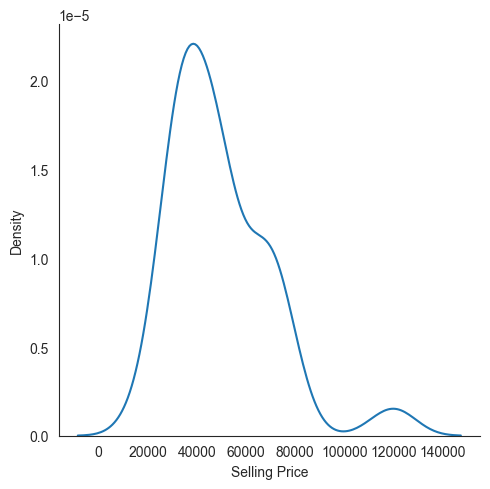

In [134]:
sns.displot(df[df['Brand Name'] == 'Apple']['Selling Price'],kind = 'kde')

In [135]:
df.groupby('Brand Name')['Rating (Out of 5)'].agg(['min','max','mean','count']).sort_values(by='count',ascending=False)

min  max      mean  count
Brand Name                           
Fossil      2.8  5.0  4.244361    133
Garmin      0.0  5.0  2.022772    101
Apple       3.4  5.0  4.545349     86
Fitbit      3.8  4.7  4.186275     51
Samsung     2.3  5.0  4.229167     48
Huami       3.7  4.4  4.152778     36
Huawei      3.4  4.5  4.161538     26
Honor       3.1  4.4  4.195000     20
Noise       3.6  4.3  4.026316     19
Realme      4.0  4.4  4.141667     12
Xiaomi      3.5  4.4  4.170000     10
Fastrack    3.8  4.1  4.016667      6
Goqii       2.8  3.8  3.350000      4
Boat        3.6  4.1  3.900000      4
Oneplus     4.2  4.4  4.300000      3
Lcare       3.5  3.8  3.650000      2
Oppo        3.9  3.9  3.900000      2
Infinix     3.8  3.8  3.800000      1
Lava        3.6  3.6  3.600000      1

In [136]:
# print(stats.pearsonr (df['Rating (Out of 5)'],df['Selling Price']))

stats.kendalltau(df['Rating (Out of 5)'],df['Selling Price'])

SignificanceResult(statistic=0.10291015977104186, pvalue=0.00046194781963810016)

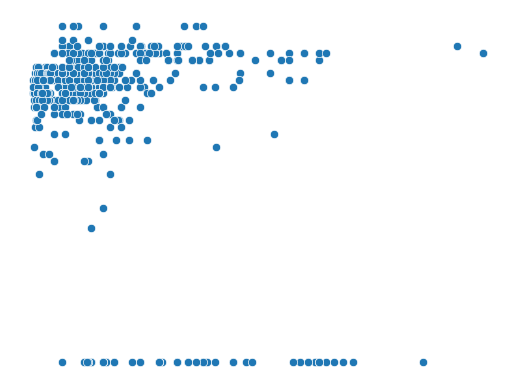

In [137]:
sns.scatterplot(data = df, x ='Selling Price', y = 'Rating (Out of 5)' )
plt.axis('off')

In [138]:
print("",stats.pearsonr(df['Selling Price'],df['Discount']))
stats.spearmanr(df['Selling Price'],df['Discount'])

 PearsonRResult(statistic=0.02947394122004006, pvalue=0.484434585412834)


SignificanceResult(statistic=-0.09071791820006728, pvalue=0.031082729796389836)

In [139]:
corr,p_val = stats.spearmanr(df['Rating (Out of 5)'],df['Selling Price'])
print(corr,p_val)

0.14469356464862188 0.0005608337989546734


In [140]:
stats.pearsonr(df['Rating (Out of 5)'],df['Discount'])

PearsonRResult(statistic=-0.18776929626283387, pvalue=7.010553091364632e-06)

In [141]:
stats.spearmanr(df['Rating (Out of 5)'],df['Discount'])

SignificanceResult(statistic=-0.12149554434657857, pvalue=0.003825037633764267)

In [142]:
df[df['Brand Name']=='Apple']['Reviews'].isna().sum()

86

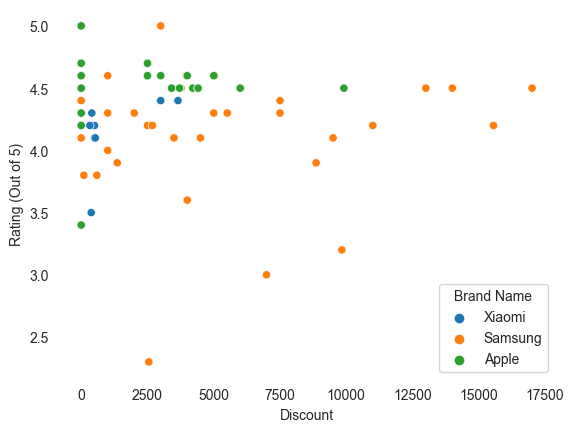

In [143]:
sns.scatterplot(data = df[df['Brand Name'].isin(['Apple','Xiaomi','Samsung'])] ,y = 'Rating (Out of 5)',x = 'Discount', hue = 'Brand Name')
sns.despine(bottom = True, left = True)
plt.show()

In [144]:
df[['Discount','Rating (Out of 5)']].sort_values(by='Discount',ascending = False)

Discount  Rating (Out of 5)
20    29693.0                4.1
474   20000.0                0.0
336   17596.0                3.8
188   17009.0                4.5
301   15996.0                4.2
..        ...                ...
430       0.0                4.6
431       0.0                4.5
432       0.0                4.6
433       0.0                4.7
564       0.0                4.2

[565 rows x 2 columns]

In [145]:
df[df['Discount']==0]['Brand Name'].value_counts()

Fossil     66
Apple      48
Garmin     25
Fitbit     18
Samsung    11
Huawei      8
Goqii       4
Honor       2
Xiaomi      1
Boat        1
Huami       1
Name: Brand Name, dtype: int64

<Axes: xlabel='Discount', ylabel='Rating (Out of 5)'>

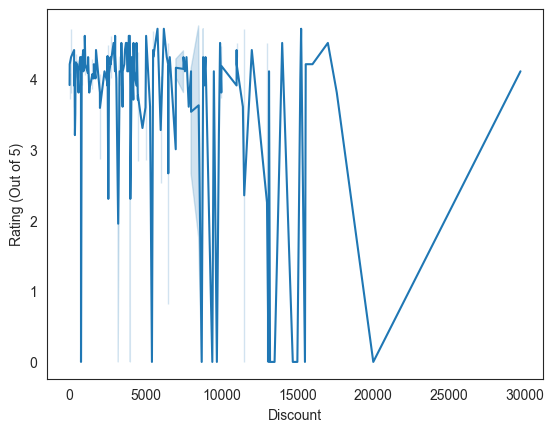

In [146]:
sns.lineplot(df,x = 'Discount', y = 'Rating (Out of 5)')

In [147]:
px.scatter(df, y = 'Discount', x = 'Rating (Out of 5)', trendline = 'ols')

In [148]:
px.scatter(df, y = 'Selling Price', x = 'Rating (Out of 5)', trendline = 'ols')

In [149]:
df.corr(method = 'spearman').unstack()['Selling Price']

Selling Price                     1.000000
Original Price                    0.955106
Rating (Out of 5)                 0.144694
Average Battery Life (in days)   -0.101486
Reviews                          -0.650029
Discount                         -0.090718
dtype: float64

In [150]:
px.box(df, x = 'Brand Name' , y = 'Discount')

In [151]:
df.groupby('Brand Name')[['Discount','Selling Price']].agg({'Discount':['std','mean','min','max'],'Selling Price':['min','mean','max']})

Discount                               Selling Price  \
                    std         mean     min      max           min   
Brand Name                                                            
Apple       2166.867575  1713.604651     0.0   9910.0       16900.0   
Boat        1932.231935  2743.250000     0.0   4491.0        2499.0   
Fastrack     161.361396   607.500000   400.0    800.0        1195.0   
Fitbit      5028.273594  3390.705882     0.0  29693.0        5299.0   
Fossil      3671.672854  2959.812030     0.0  17596.0        3799.0   
Garmin      4464.200089  5082.702970     0.0  20000.0        8990.0   
Goqii          0.000000     0.000000     0.0      0.0        1999.0   
Honor       3117.491054  2314.050000     0.0  10000.0        1649.0   
Huami       2515.002975  3573.083333     0.0   8000.0        1999.0   
Huawei      4221.971832  4876.923077     0.0  12000.0        1699.0   
Infinix             NaN  1500.000000  1500.0   1500.0        1499.0   
Lava                NaN  1500.000000  1500.0   1500.0        1999.0   
Lcare        144.249783  1398.000000  1296.0   1500.0        1699.0   
Noise        827.317811  2499.263158   300.0   4000.0        1699.0   
Oneplus      888.819442  1000.000000   300.0   2000.0        2499.0   
Oppo        1414.213562  6000.000000  5000.0   7000.0       14990.0   
Realme       977.525397  1804.583333   500.0   3078.0        1290.0   
Samsung     4406.302641  4079.395833     0.0  17009.0        2000.0   
Xiaomi      1260.154770   968.600000     0.0   3650.0        1270.0   

                                    
                    mean       max  
Brand Name                          
Apple       49413.837209  122090.0  
Boat         4246.750000    7990.0  
Fastrack     1754.166667    2495.0  
Fitbit      14018.843137   26499.0  
Fossil      13824.954887   25995.0  
Garmin      35038.227723  105990.0  
Goqii        3124.000000    3999.0  
Honor        5510.000000   17999.0  
Huami        7547.638889   13999.0  
Huawei      15874.615385   55000.0  
Infinix      1499.000000    1499.0  
Lava         1999.000000    1999.0  
Lcare        2347.000000    2995.0  
Noise        3183.947368    5999.0  
Oneplus      6932.333333   14999.0  
Oppo        16490.000000   17990.0  
Realme       4402.750000    9999.0  
Samsung     22901.375000   50408.0  
Xiaomi       4100.400000   12999.0

In [152]:
idx = df.groupby('Brand Name')['Discount'].idxmax()

In [153]:
df.loc[idx,['Brand Name','Original Price','Discount']]

Brand Name  Original Price  Discount
384      Apple         49900.0    9910.0
111       Boat          7990.0    4491.0
108   Fastrack          1995.0     800.0
20      Fitbit         38500.0   29693.0
336     Fossil         21995.0   17596.0
474     Garmin         79990.0   20000.0
86       Goqii          2999.0       0.0
134      Honor         17999.0   10000.0
161      Huami         18999.0    8000.0
550     Huawei         20990.0   12000.0
88     Infinix          2999.0    1500.0
91        Lava          3499.0    1500.0
89       Lcare          4495.0    1500.0
128      Noise          9999.0    4000.0
541    Oneplus         16999.0    2000.0
95        Oppo         24990.0    7000.0
103     Realme          6999.0    3078.0
188    Samsung         33999.0   17009.0
7       Xiaomi         15999.0    3650.0

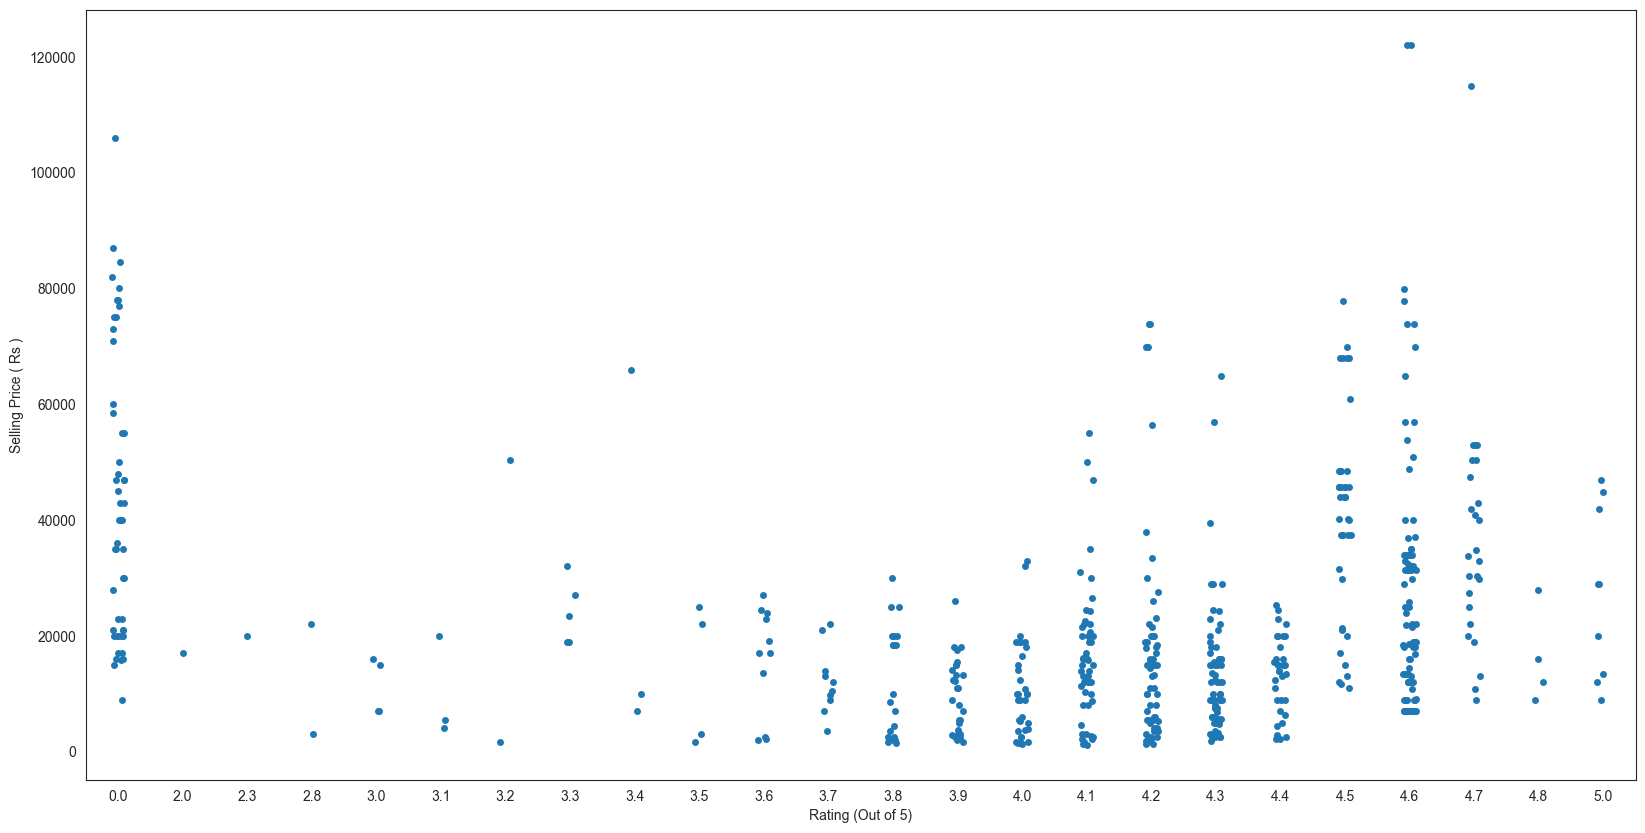

In [154]:
plt.figure(figsize=(20,10))
ax = sns.stripplot(x="Rating (Out of 5)", y="Selling Price", data=df)
plt.ylabel("Selling Price ( Rs )")
plt.show()

<Axes: >

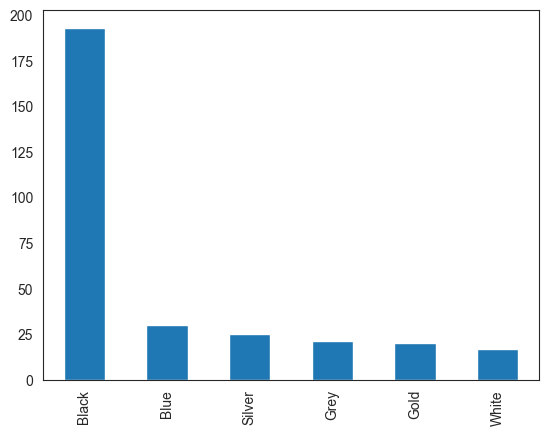

In [155]:
# Top 5 colors
df['Color'].value_counts()[:6].plot.bar()

In [156]:
df[df['Reviews'].isna()]

Brand Name  Device Type             Model Name             Color  \
0       Xiaomi  FitnessBand           Smart Band 5             Black   
1       Xiaomi  FitnessBand           Smart Band 4             Black   
2       Xiaomi  FitnessBand               HMSH01GE             Black   
3       Xiaomi  FitnessBand           Smart Band 5             Black   
4       Xiaomi  FitnessBand                 Band 3             Black   
..         ...          ...                    ...               ...   
560     Huawei   Smartwatch            Watch 36456             Black   
561     Huawei   Smartwatch  GT Fortuna-B19S Sport             Black   
562      Goqii  FitnessBand                     HR             Black   
563      Goqii  FitnessBand                  Vital             Black   
564     Fossil   Smartwatch                 Gen 5E  Grey, Multicolor   

     Selling Price  Original Price         Display  Rating (Out of 5)  \
0           2499.0          2999.0  AMOLED Display                4.1   
1           2099.0          2499.0  AMOLED Display                4.2   
2           1722.0          2099.0     LCD Display                3.5   
3           2469.0          2999.0  AMOLED Display                4.1   
4           1799.0          2199.0    OLED Display                4.3   
..             ...             ...             ...                ...   
560        55000.0         55000.0  AMOLED Display                4.1   
561        13990.0         20990.0  AMOLED Display                4.1   
562         1999.0          1999.0    OLED Display                3.8   
563         3499.0          3499.0    OLED Display                3.7   
564        18495.0         18495.0  AMOLED Display                4.2   

                 Strap Material  Average Battery Life (in days)  Reviews  \
0    Thermoplastic polyurethane                              14      NaN   
1    Thermoplastic polyurethane                              14      NaN   
2                       Leather                              14      NaN   
3    Thermoplastic polyurethane                              14      NaN   
4                       Plastic                               7      NaN   
..                          ...                             ...      ...   
560                    Silicone                              14      NaN   
561                   Elastomer                              14      NaN   
562                    Silicone                               7      NaN   
563  Thermoplastic polyurethane                               7      NaN   
564             Stainless Steel                               1      NaN   

     Discount  
0       500.0  
1       400.0  
2       377.0  
3       530.0  
4       400.0  
..        ...  
560       0.0  
561    7000.0  
562       0.0  
563       0.0  
564       0.0  

[488 rows x 12 columns]